In [68]:
import os
import pypsa
import random
import requests
import numpy as np
import pandas as pd
from io import StringIO
from pathlib import Path
import matplotlib.pyplot as plt

In [69]:
date = '2024-03-06'
period = 18

In [70]:
def get_price(date, period):

    price_template = "https://data.elexon.co.uk/bmrs/api/v1/balancing/pricing/market-index?from={}T00:00Z&to={}T00:00Z&settlementPeriodFrom={}&settlementPeriodTo={}"

    url = price_template.format(date, date, period, period)
    response = requests.get(url)
    df = pd.read_csv(StringIO(response.text))

    for col1, col2 in zip(df.columns[:-1], df.columns[1:]):
        if not ('price' in col1 and 'volume' in col2):
            continue
        print(col2)

        return float(col1.split(':')[-1])


def get_bm_data(date, period):
    data = pd.read_csv(Path.cwd().parent / 'resources' / 'live_data' / f'{date}_{period}' / 'elexon_bmus.csv', index_col=0)

    return data['PN']


price = get_price(date, period)

volume:2690.550}


In [71]:
def get_model(date, period, layout='nodal'):
    return pypsa.Network(Path.cwd().parent / 'resources' / 'live_data' / f'{date}_{period}' / f'network_s_{layout}_solved.nc')

n = get_model(date, period)

carrier_grouper = {
    'hydro': 'hydro',
    'hydro-scheme': 'hydro',
    'wind': 'offwind',
    'floating wind': 'offwind',
    'CCGT': 'gas',
    'solar power station': 'solar',
    'PV': 'solar',
    'PHS': 'hydro',
}

n.generators['carrier'] = n.generators.carrier.map(lambda x: carrier_grouper[x] if x in carrier_grouper else x)

colors = {
    "onwind": "#235ebc",
    "offwind": "#6895dd",
    "hydro": "#298c81",
    "CHP": "#8a5751",
    "coal": "#545454",
    "biomass": "#baa741",
    "gas": "#a85522",
    "nuclear": '#ff8c00',
    "interconnector": "#8a1caf",
    "cascade": "#46caf0",
    "solar": "#f9d002",
    "battery": '#ace37f',
}

Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_nodal_solved.nc has buses, carriers, generators, lines, links, loads


In [76]:
bmu_loc = pd.read_csv(Path.cwd().parent / 'resources' / 'bmunits_loc.csv', index_col=0)[['lat', 'lon']]

Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_nodal_solved.nc has buses, carriers, generators, lines, links, loads
Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_eso_solved.nc has buses, carriers, generators, lines, links, loads
Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_fti_solved.nc has buses, carriers, generators, lines, links, loads
Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, loads


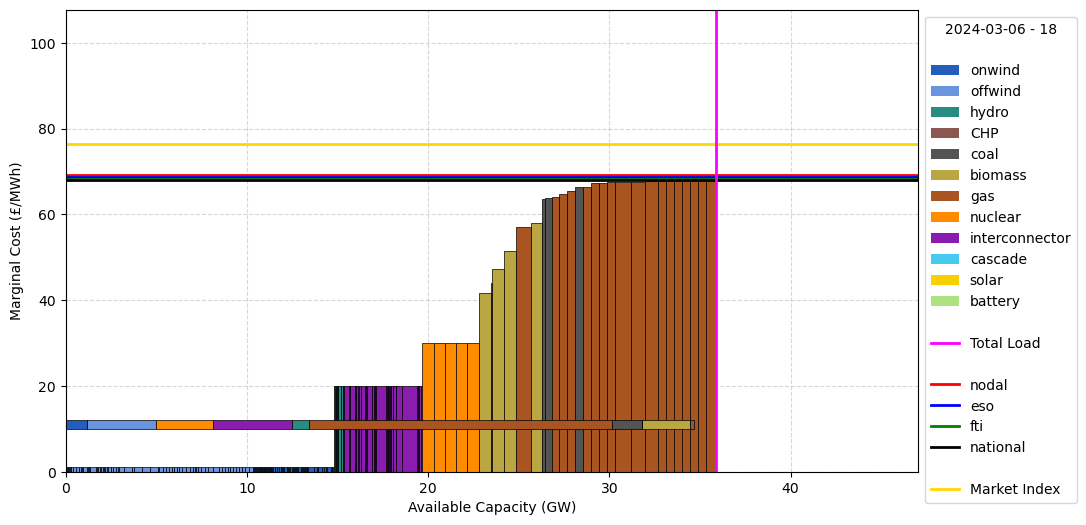

In [128]:
from shapely.geometry import Point

fig, ax = plt.subplots(1, 1, figsize=(11, 6))

bm_data = get_bm_data(date, period)

gen = n.generators.sort_values(by=['marginal_cost', 'carrier'])
gen = pd.concat((
    gen, n.generators_t.p.T.rename(columns={n.generators_t.p.index[0]: 'p'})
), axis=1)
gen.drop(gen[gen.p_nom == 0].index, inplace=True)

gen = pd.concat((gen, bmu_loc.loc[gen.index], bm_data.loc[gen.index].mul(1e-3)), axis=1)
gen["geometry"] = gen.apply(lambda x: Point(x.lon, x.lat), axis=1)

gen[["p_nom", "p"]] *= 1e-3

gen['diff'] = gen['p_nom'] - gen['p']

gen['total_p_nom'] = gen['p_nom'].cumsum()
gen['total_p'] = gen['p'].cumsum()

col = 'p'

for i, (bmu, row) in enumerate(gen.iterrows()):
    
    # ax.bar(bmu, row['p_nom'], color=colors[row['carrier']], edgecolor='black', linewidth=0.5)
    ax.bar(
        # row.total_p_nom - row.p_nom/2,
        row['total_'+col] - row[col]/2,
        max(row.marginal_cost, 1),
        width=row[col],
        # bottom=row.total_p_nom - row.p_nom,
        color=colors[row.carrier],
        edgecolor='black',
        linewidth=0.5,
        )

handles = []
labels = []
labels.append('')
handles.append(plt.Line2D([0], [0], color='w', lw=0, label=''))

for color, carrier in zip(colors.values(), colors.keys()):
    if not carrier in gen.carrier.values:
        continue

    handles.append(plt.Rectangle((0, 0), 1, 1, fc=color))
    labels.append(carrier)

labels.append('')
handles.append(plt.Line2D([0], [0], color='w', lw=0, label=''))

load_color = 'magenta'
labels.append('Total Load')
handles.append(plt.Line2D([0], [0], color=load_color, lw=2, label=''))

labels.append('')
handles.append(plt.Line2D([0], [0], color='w', lw=0, label=''))


lcolors = {
    'national': 'black',
    'eso': 'blue',
    'fti': 'green',
    'nodal': 'red',
}

for l in ['nodal', 'eso', 'fti', 'national']:
    ln = get_model(date, period, layout=l)

    max_price = ln.buses_t.marginal_price.max().max()
    ax.axhline(max_price, color=lcolors[l], lw=2)

    handles.append(plt.Line2D([0], [0], color=lcolors[l], lw=2))
    labels.append(l)

ax.axhline(price, color='gold', lw=2)
labels.append('')
handles.append(plt.Line2D([0], [0], color='w', lw=0, label=''))

labels.append('Market Index')
handles.append(plt.Line2D([0], [0], color='gold', lw=2))

ax.legend(
    handles,
    labels,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    title=f'{date} - {period}',
    )

ax.set_xlabel('Available Capacity (GW)')
ax.set_ylabel('Marginal Cost (£/MWh)')

ax.axvline(n.loads.p_set.sum() * 1e-3, color=load_color, lw=2)
ax.set_xlim(0, gen.p_nom.sum())

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

# ax.axvline(bm_data.loc[bm_data > 0].sum()*1e-3, color=load_color, lw=5)
carrier_dispatch = (
    pd.concat((
        gen[['carrier', 'p_nom', 'marginal_cost']],
        bm_data.mul(1e-3)
        ), axis=1)
    .loc[gen.index]
    .groupby('carrier')[['PN']].sum()
    .iloc[::-1]
)

carrier_dispatch['total'] = carrier_dispatch.cumsum()

for carrier, row in carrier_dispatch.loc[gen.carrier.unique()].iterrows():
    ax.bar(row.total - row.PN/2, 2, width=row.PN, bottom=10, color=colors[carrier], edgecolor='black', linewidth=0.5)

plt.show()

c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\IPython\core\interactiveshell.py:3526: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


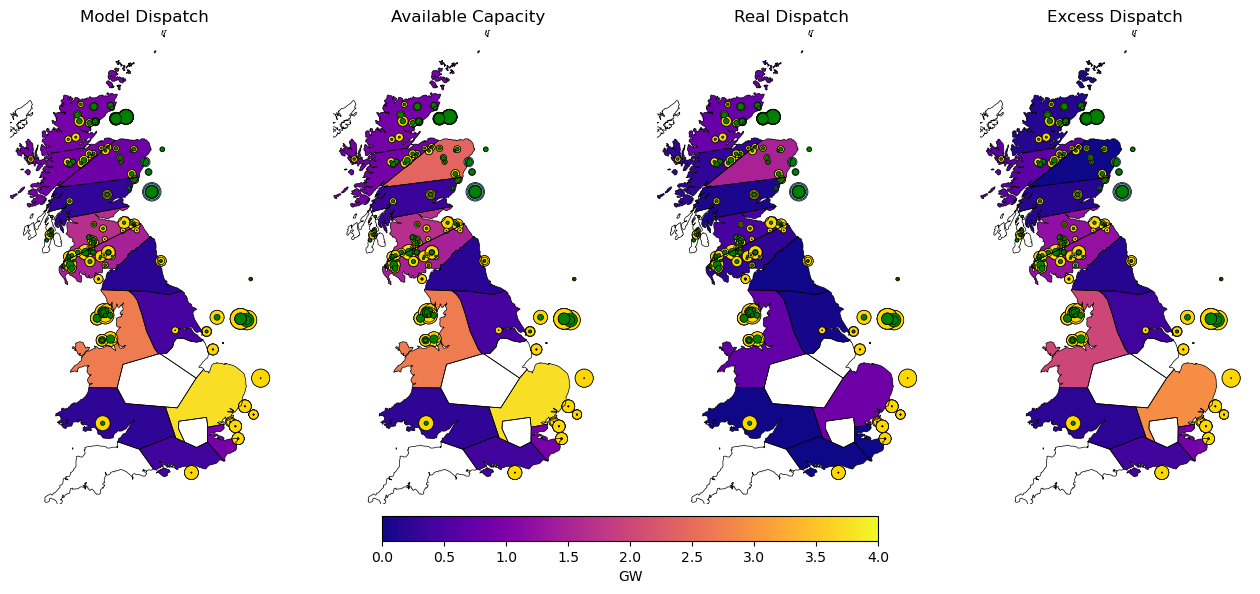

In [175]:
import geopandas as gpd
# shapes = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
regions = gpd.read_file(Path.cwd().parent / 'data' / 'eso_zones.geojson').set_crs(epsg=4326)
all_regions = regions.copy()

buses = gpd.GeoDataFrame(n.buses, geometry=gpd.points_from_xy(n.buses.x, n.buses.y))

wind = gpd.GeoDataFrame(
    gen.loc[gen.carrier.str.contains('wind')],
    geometry='geometry',
    crs='EPSG:4326'
)
wind_farms = wind.copy()

wind = wind.loc[wind.bus != '']
# wind['bus'] = wind.bus.map(n.buses.name)

# print('before ')
# print(wind.geometry)

wind['geometry'] = wind['bus'].apply(lambda x: buses.loc[x].geometry)

# print('after ')
# print(wind.geometry)

# fig, ax = plt.subplots(1, 1, figsize=(11, 6))
# regions.boundary.plot(ax=ax, color='black', linewidth=0.5)
# wind.plot(ax=ax)
# buses.plot(ax=ax)
# plt.show()

regions = regions.sjoin(wind[["carrier", 'marginal_cost', "p_nom", 'p', 'PN', 'geometry', 'diff']], how='inner', op='intersects')

regions["excess"] = regions['p'] - regions['PN']

regions = regions.groupby('name')[['p_nom', 'p', 'excess', 'PN', 'geometry']].agg({
    'p_nom': 'sum',
    'p': 'sum',
    'excess': 'sum',
    'PN': 'sum',
    'geometry': 'first'
})

regions = gpd.GeoDataFrame(regions, crs='EPSG:4326')

fig, axs = plt.subplots(1, 4, figsize=(16, 15))

vmin = 0.
vmax = 4.
titles = {
    'p': 'Model Dispatch',
    'p_nom': 'Available Capacity',
    'PN': 'Real Dispatch',
    'excess': 'Excess Dispatch',

}

cm = 'plasma'
for ax, col in zip(axs, ['p', 'p_nom', 'PN', 'excess']):

    regions.plot(
        ax=ax,
        column=col,
        cmap=cm,
        # legend=True,
        # legend_kwds={'label': "GW", 'orientation': "horizontal"},
        # edgecolor='black',
        linewidth=0.5,
        vmin=vmin,
        vmax=vmax,
        )

    wind_farms.plot(
        ax=ax,
        color='skyblue',
        markersize=wind_farms['p_nom']*500,
        # alpha=0.5,
        edgecolor='black',
        linewidth=0.5
        )
    wind_farms.plot(
        ax=ax,
        color='gold',
        markersize=wind_farms['p']*500,
        # alpha=0.5,
        edgecolor='black',
        linewidth=0.5
        )
    (
        wind_farms
        #.translate(xoff=0.1, yoff=0.1)
        .plot(
            ax=ax,
            color='green',
            markersize=wind_farms['PN']*500,
            alpha=1,
            edgecolor='black',
            linewidth=0.5
        )
    )
    
    ax.set_title(titles[col])

    ax.set_xlim(-7, 3)
    ax.set_ylim(50, 60)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])

    all_regions.boundary.plot(ax=ax, color='black', linewidth=0.5)

import matplotlib as mpl

fig.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin, vmax),
        cmap=cm),
        ax=axs[:],
        orientation='horizontal',
        label='GW',
        shrink=0.4,
        pad=0.01,
        )
    
# pcm = ax.pcolormesh(np.random.random((20, 20)) * (col + 1), cmap=cm)
# fig.colorbar(pcm, ax=axs[:, col], shrink=0.6)

plt.savefig('wind_dispatch.pdf')
plt.show()

In [183]:
pd.concat((wind['p'] - wind['PN'], wind[['p', 'PN']]), axis=1).rename(columns={0: 'excess'}).sort_values('excess')

,excess,p,PN
Generator,,,
MOWEO-3,-0.207,0.000,0.207
SGRWO-6,-0.193,0.000,0.193
SGRWO-1,-0.153,0.000,0.153
SGRWO-3,-0.085,0.000,0.085
SGRWO-4,-0.079,0.000,0.079
...,...,...,...
WHILW-1,0.284,0.305,0.021
HOWBO-1,0.301,0.440,0.139
HOWBO-2,0.301,0.440,0.139


In [136]:
print(wind[['p_nom', 'p', 'PN']].sum())
print(regions[['p_nom', 'p', 'PN']].sum())

p_nom    16.369000
p        14.698194
PN        4.927000
dtype: float64
p_nom    16.369000
p        14.698194
PN        4.927000
dtype: float64


In [14]:

get_bm_data(date, period)


NationalGridBmUnit
PINFD-5      0
PINFD-6      0
RUSHB-1      0
TYLNB-1      0
UNPKD-1      0
          ... 
SGRWO-2     39
SGRWO-1    153
LAGA-1     821
KEAD-2     834
HADHW-1     14
Name: PN, Length: 1879, dtype: int64